In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from math import log10
%matplotlib inline
start_time = pd.datetime.now()
import copy
import datetime
import scipy.stats as stats
import timeit

<ipython-input-2-3a65075d0fc1>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_time = pd.datetime.now()


In [3]:
df = pd.read_csv('card transactions.csv') 
df = df.iloc[:, 0:10]

# extractions

52714    3102045.53
47339      47900.00
59516      30372.46
80886      28392.84
89673      27218.00
            ...    
47165          0.08
57855          0.02
78387          0.01
91179          0.01
56124          0.01
Name: Amount, Length: 96753, dtype: float64

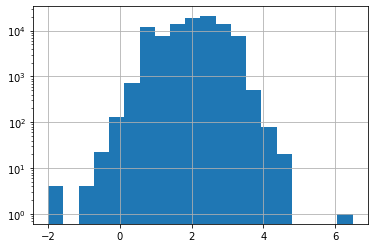

In [4]:
#1. Remove Single large transaction outlier
np.log10(df['Amount']).hist(bins=20)
plt.yscale('log')

df['Amount'].sort_values(ascending = False)

In [5]:
df=df[df['Amount']!=3102045.53]

In [6]:
# Remove all but the “P” type transactions
df=df[df['Transtype']=='P']

In [7]:
df.describe()

,Recnum,Cardnum,Merch zip,Amount,Fraud
count,96397.000000,9.639700e+04,92097.000000,96397.000000,96397.000000
mean,48365.481820,5.142202e+09,44706.596740,395.858494,0.010986
std,27945.003883,5.565825e+04,28369.537945,832.330197,0.104236
min,1.000000,5.142110e+09,1.000000,0.010000,0.000000
25%,24154.000000,5.142152e+09,20855.000000,33.460000,0.000000
50%,48365.000000,5.142196e+09,38118.000000,137.980000,0.000000
75%,72578.000000,5.142245e+09,63103.000000,428.250000,0.000000
max,96753.000000,5.142847e+09,99999.000000,47900.000000,1.000000


In [8]:
df['Merchnum'].sort_values(ascending=False)

30370    PENNE9 CO #68
6534     PENNE9 CO #05
44789      JCPENNE9 CO
53557      JCPENNE9 CO
38452      JCPENNE9 CO
             ...      
96621              NaN
96651              NaN
96689              NaN
96720              NaN
96730              NaN
Name: Merchnum, Length: 96397, dtype: object

In [9]:
df['Merchnum']=df['Merchnum'].replace('0',np.nan)

In [10]:
print(df.isna().sum())

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3251
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64


In [11]:
df = df.reset_index()

# Fill Missing Values

In [12]:
df_filled = df.copy()

In [13]:
missing_state = np.where(pd.isnull(df_filled['Merch state']))[0]
len(missing_state)

1020

In [14]:
# If the record has a zip, use the state for that zip, if known
import statistics
temp = df_filled[pd.isnull(df_filled['Merch state'])==False]
mode_zip = temp.groupby('Merch zip')['Merch state'].apply(statistics.mode)
print(mode_zip)

Merch zip
1.0        PA
2.0        VA
3.0        GA
5.0        IA
6.0        IL
           ..
99755.0    AK
99801.0    AK
99835.0    AK
99901.0    AK
99999.0    CA
Name: Merch state, Length: 4538, dtype: object


In [15]:
for index in mode_zip.index:
    df_filled.loc[(pd.isnull(df_filled['Merch state'])==True)&(df_filled['Merch zip']==index), 'Merch state']= mode_zip[index]

In [16]:
missing_state = np.where(pd.isnull(df_filled['Merch state']))[0]
len(missing_state)

1000

In [17]:
# If in range 00600 – 00799, 00900 – 00999: state = PR (Puerto Rico)
for i in range(len(missing_state)):
    if ((df_filled.loc[missing_state[i], 'Merch zip'] >= 600) & (df_filled.loc[missing_state[i], 'Merch zip']<=799)):
        df_filled.loc[missing_state[i], 'Merch state'] = 'PR'
    elif ((df_filled.loc[missing_state[i], 'Merch zip'] >= 900) & (df_filled.loc[missing_state[i], 'Merch zip']<=999)):
        df_filled.loc[missing_state[i], 'Merch state'] = 'PR'
    else:
        pass

In [18]:
missing_state = np.where(pd.isnull(df_filled['Merch state']))[0]
len(missing_state)

960

In [19]:
# Use the mode of the Merchnum or Merch description
temp = df_filled[pd.isnull(df_filled['Merch state'])== False]
mode_merchdes = temp.groupby('Merch description')['Merch state'].apply(statistics.mode)
print(mode_merchdes)

Merch description
#9 SOFTWARE                 VA
(ISC)2 CERTIFICATION        MA
0000000000000000000000      WA
033007 KINKO'S              NC
05032 FLYING J              NM
                            ..
ZYMARK CORPORATION          MA
ZYMAX ENVIROTECHNOLOGY      CA
ZYMED LABORATORIES          CA
ZZYZX WORKSTATIONS          CA
ZZYZX WRKSTNS PERIPHERAL    CA
Name: Merch state, Length: 12844, dtype: object


In [20]:
for index in mode_merchdes.index:
    df_filled.loc[(pd.isnull(df_filled['Merch state'])==True)&(df_filled['Merch description']==index), 'Merch state']= mode_merchdes[index]

In [21]:
missing_state = np.where(pd.isnull(df_filled['Merch state']))[0]
len(missing_state)

296

In [22]:
# Fill in with “Unk” for unknown
for i in range(len(missing_state)):
    if np.isnan(df_filled.loc[missing_state[i], 'Merch state']):
        df_filled.loc[missing_state[i], 'Merch state'] = 'Unk'
    else:
        pass

In [23]:
missing_state = np.where(pd.isnull(df_filled['Merch state']))[0]
len(missing_state)

0

# Fill Merchnum

In [24]:
# If = 0, replace with NaN
df_filled['Merchnum'] = df_filled['Merchnum'].replace(0, 'NaN')

In [25]:
missing_num = np.where(pd.isnull(df_filled['Merchnum']))[0]
len(missing_num)

3251

In [26]:
# Fill in with mode of Merch description
temp = df_filled[pd.isnull(df_filled['Merchnum'])== False]
mode_merchnum = temp.groupby('Merch description')['Merchnum'].apply(statistics.mode)
print(mode_merchnum)

Merch description
#9 SOFTWARE                 6000330882278
(ISC)2 CERTIFICATION            590065510
0000000000000000000000      8168600400097
033007 KINKO'S                35068136338
05032 FLYING J              121075089FL96
                                ...      
ZYMARK CORPORATION           988906278331
ZYMAX ENVIROTECHNOLOGY      9612006916900
ZYMED LABORATORIES           679966068337
ZZYZX WORKSTATIONS          6163608306809
ZZYZX WRKSTNS PERIPHERAL    6163608306809
Name: Merchnum, Length: 12456, dtype: object


In [27]:
for index in mode_merchnum.index:
    df_filled.loc[(pd.isnull(df_filled['Merchnum'])==True)&(df_filled['Merch description']==index), 'Merchnum']= mode_merchnum[index]

In [28]:
missing_num = np.where(pd.isnull(df_filled['Merchnum']))[0]
len(missing_num)

2094

In [30]:
# Fill in with unknown
for i in range(len(missing_num)):
    if np.isnan(df_filled.loc[missing_num[i], 'Merchnum']):
        df_filled.loc[missing_num[i], 'Merchnum'] = 'Unk'
    else:
        pass

In [31]:
missing_num = np.where(pd.isnull(df_filled['Merchnum']))[0]
len(missing_num)

0

# Fill Merch zip

In [32]:
missing_zip = np.where(pd.isnull(df_filled['Merch zip']))[0]
len(missing_zip)

4300

In [33]:
# Fill in with with mode of merchant number
temp = df_filled[pd.isnull(df_filled['Merch zip'])== False]
mode_merchzip = temp.groupby('Merchnum')['Merch zip'].apply(statistics.mode)
print(mode_merchzip)

Merchnum
003100006NOT6    41011.0
004740006ABC6    82520.0
005590006PNB6    80439.0
014430619  14    90502.0
014938913  51    84116.0
                  ...   
DU49038320006    19547.0
JCPENNE9 CO      48108.0
PENNE9 CO #05    43623.0
PENNE9 CO #68    40422.0
Unk              21045.0
Name: Merch zip, Length: 12834, dtype: float64


In [34]:
for index in mode_merchzip.index:
    df_filled.loc[(pd.isnull(df_filled['Merch zip'])==True)&(df_filled['Merchnum']==index), 'Merch zip']= mode_merchzip[index]

In [35]:
missing_zip = np.where(pd.isnull(df_filled['Merch zip']))[0]
len(missing_zip)

1101

In [36]:
# Fill in with unknown
for i in range(len(missing_zip)):
    if np.isnan(df_filled.loc[missing_zip[i], 'Merch zip']):
        df_filled.loc[missing_zip[i], 'Merch zip'] = 'Unk'
    else:
        pass

In [37]:
missing_zip = np.where(pd.isnull(df_filled['Merch zip']))[0]
len(missing_zip)

0

In [38]:
df_filled.isna().sum()

index                0
Recnum               0
Cardnum              0
Date                 0
Merchnum             0
Merch description    0
Merch state          0
Merch zip            0
Transtype            0
Amount               0
Fraud                0
dtype: int64

In [39]:
df_filled.to_csv("df_filled.csv")